In [1]:
from copy import copy
import random
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split, Subset
from torch.optim import lr_scheduler

import albumentations as A  # Image augmentations


from mri_dataset import get_mri_datasets
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


In [2]:
from song_code_reproduction.src.mri_vit import ViT_Encoder_Decoder

from song_code_reproduction.src.sign_encoding_loss import (
    SignEncodingPenalty,
    select_all_params,
    bytes_to_images_torch,
    capacity_report,
)

In [36]:
save_path = "/dt/yisroel/Users/Data_Memorization/song_memorization/SIGN/mri/"

memorization_size = 10

# Training Params
BATCH_SIZE = 16
num_epochs = 600 # Example number of epochs
LEARNING_RATE = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [37]:
mem_transform = A.Compose([
                            A.Resize(width=128, height=128, p=1.0),
])

mem_train_dataset, train_dataset, val_dataset, test_dataset = get_mri_datasets(root_path='mri_data/',mem_train_transform_obj=mem_transform)

trainloader = DataLoader(train_dataset, 
                      BATCH_SIZE, 
                      shuffle=True, 
                      num_workers=6,  
                      pin_memory=True)  
valloader = DataLoader(val_dataset, 
                    BATCH_SIZE,   
                    num_workers=6, 
                    pin_memory=True)

testloader = DataLoader(test_dataset, 
                    BATCH_SIZE,   
                    num_workers=6, 
                    pin_memory=True)

if memorization_size > len(mem_train_dataset):
    memorization_size = len(mem_train_dataset)
memorization_indices = torch.randperm(len(mem_train_dataset))[:memorization_size].tolist()
memorization_set = Subset(mem_train_dataset, memorization_indices)

print("DataLoaders created successfully!")
print(f"Number of images in training set: {len(train_dataset)}")
print(f"Number of images in validation set: {len(val_dataset)}")
print(f"Number of images in test set: {len(test_dataset)}")
print(f"Number of images in memorization set: {memorization_size}")

DataLoaders created successfully!
Number of images in training set: 3182
Number of images in validation set: 393
Number of images in test set: 354
Number of images in memorization set: 100


In [38]:
len(memorization_set), memorization_set[0][0].size()

(100, torch.Size([3, 128, 128]))

In [39]:
model = ViT_Encoder_Decoder().to(device)

In [42]:
sign_penalty = SignEncodingPenalty(
    model=model,
    dataset=memorization_set,
    subset_selector=select_all_params,
    lambda_max=50.0,
    margin=1e-3,
    redundancy_k=5,         # IMPORTANT: maximize capacity for visible recon
    device=device,
    float_mode="clip01",
)

print(capacity_report(sign_penalty, bits_per_image=3*128*128*8))

def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union

# Function to calculate the Dice coefficient loss between prediction and ground truth.
def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)

# Function to calculate the combined BCE (Binary Cross Entropy) and Dice loss.

def bce_dice_loss(pred, label):
    pred = torch.sigmoid(pred) 
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss

criterion = bce_dice_loss

optimizer = optim.AdamW(model.parameters(), lr= LEARNING_RATE, weight_decay=0)

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

print("Training hyperparameters and objects defined.")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Number of Epochs: {num_epochs}")
print(f"Loss Function: {type(criterion).__name__}")
print(f"Optimizer Type: {type(optimizer).__name__}")
print(f"Scheduler Type: {type(scheduler).__name__}")
print(f"Device: {device}")

Capacity: subset L=21698176, redundancy k=5, available bits B=4339635, fits ~11 images
Training hyperparameters and objects defined.
Learning Rate: 0.0001
Number of Epochs: 600
Loss Function: function
Optimizer Type: AdamW
Scheduler Type: CosineAnnealingLR
Device: cuda


In [8]:
import torch
import time
import os

def train_batch(images, labels, model, optimizer, criterion, step, total_steps, device):
    images, labels = images.to(device), labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels) + sign_penalty(step, total_steps)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

def evaluate_batch(images, mask, model, criterion, device):
    images, mask = images.to(device), mask.to(device)
    with torch.no_grad():
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, mask)

        # Calculate accuracy
        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
        dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())

    return loss.item(), dice, mask.size(0)

def main_train_loop(model, trainloader, valloader, optimizer, criterion, scheduler, num_epochs, device, save_path):
    best_train_loss = float('inf')
    
    total_steps = num_epochs * len(trainloader)
    step = 0

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        start_time = time.time()
        # Training phase
        for i, (images, labels) in enumerate(trainloader):
            loss = train_batch(images, labels, model, optimizer, criterion, step, total_steps, device)
            running_loss += loss
            step += 1

        epoch_loss = running_loss / len(trainloader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        dice_predictions = 0
        total_predictions = 0
        for images, labels in valloader:
            loss, dice, _ = evaluate_batch(images, labels, model, criterion, device)
            val_loss += loss
            dice_predictions += dice
            total_predictions += 1

        epoch_val_loss = val_loss / len(valloader)
        dice = dice_predictions / total_predictions

        end_time = time.time()
        epoch_time = end_time - start_time

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, '
              f'Val Dice: {dice:.4f}, '
              f'Epoch Time: {epoch_time:.2f}s')

        # Step the scheduler
        scheduler.step()

        # Save the best model based on training loss
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            model_save_path = os.path.join(save_path, 'best_model.pth')
            torch.save(model.state_dict(), model_save_path)
            print(f"Saved best model to {model_save_path} with training loss: {best_train_loss:.4f}")


        model.train() # Set model back to training mode
        model_save_path = os.path.join(save_path, 'last_model.pth')
        torch.save(model.state_dict(), model_save_path)

    print('Finished Training')


In [9]:
main_train_loop(model, trainloader, valloader, optimizer, criterion, scheduler, num_epochs, device, save_path)

Epoch [1/600], Train Loss: 0.8311, Val Loss: 0.6575, Val Dice: 0.4060, Epoch Time: 7.55s
Saved best model to /dt/yisroel/Users/Data_Memorization/song_memorization/SIGN/mri/best_model.pth with training loss: 0.8311
Epoch [2/600], Train Loss: 0.6478, Val Loss: 0.6023, Val Dice: 0.4684, Epoch Time: 6.12s
Saved best model to /dt/yisroel/Users/Data_Memorization/song_memorization/SIGN/mri/best_model.pth with training loss: 0.6478
Epoch [3/600], Train Loss: 0.6287, Val Loss: 0.5651, Val Dice: 0.4981, Epoch Time: 5.89s
Saved best model to /dt/yisroel/Users/Data_Memorization/song_memorization/SIGN/mri/best_model.pth with training loss: 0.6287
Epoch [4/600], Train Loss: 0.5531, Val Loss: 0.4772, Val Dice: 0.5818, Epoch Time: 6.04s
Saved best model to /dt/yisroel/Users/Data_Memorization/song_memorization/SIGN/mri/best_model.pth with training loss: 0.5531
Epoch [5/600], Train Loss: 0.5456, Val Loss: 0.4587, Val Dice: 0.5960, Epoch Time: 5.93s
Saved best model to /dt/yisroel/Users/Data_Memorization

## Test model after training

In [10]:
import torch
import os

# Define the path to the saved model
save_path = "/dt/yisroel/Users/Data_Memorization/song_memorization/SIGN/mri/"
model_save_path = os.path.join(save_path, 'last_model.pth')

# Instantiate the model (make sure the model architecture is defined in a previous cell)
# Assuming 'model' is already defined and is an instance of your ViT class
# model = VisionTransformer(...) # If not already defined, define it here with the correct parameters

# Load the saved state dictionary
if os.path.exists(model_save_path):
    model.load_state_dict(torch.load(model_save_path))
    print(f"Model loaded successfully from {model_save_path}")
else:
    print(f"No model found at {model_save_path}")

# Move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model is on device: {next(model.parameters()).device}")

Model loaded successfully from /dt/yisroel/Users/Data_Memorization/song_memorization/SIGN/mri/last_model.pth
Model is on device: cuda:0


In [11]:
import torch

def test_model(model, testloader, device):
    # Set the model to evaluation mode
    model.eval()

    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Iterate over the test data
    with torch.no_grad():
        for images, labels in testloader:
            loss, correct, _ = evaluate_batch(images, labels, model, criterion, device)
            test_loss += loss
            correct_predictions += correct
            total_predictions += 1

    # Calculate average test loss and accuracy
    average_test_loss = test_loss / len(testloader)
    test_accuracy = correct_predictions / total_predictions

    print(f'Test Loss: {average_test_loss:.4f}, Test DICE: {test_accuracy:.4f}')

## CVE encoding test

In [12]:
from song_code_reproduction.src.ssim_eval import ssim
from song_code_reproduction.src.pruning import prune_model_global_l1

from song_code_reproduction.src.sign_encoding_loss import (select_all_params, bytes_to_images_torch,
                                                           decode_bytes_from_given_model, bytes_to_images_torch)


In [33]:
def calc_ssim(recovered_imgs, memorization_set, memorization_size):
    ssim_scores = []
    for i in range(len(recovered_imgs)):
        with torch.no_grad():
            src = (memorization_set[i][0].unsqueeze(0)*255).float()
            dec = recovered_imgs[i].unsqueeze(0).float()
            ssim_score = 0.5*(1+ssim(dec, src))
            ssim_scores.append(ssim_score)
    ssim_scores = torch.tensor(ssim_scores)
    return ssim_scores.mean()



Decoded bytes: 491520 → can reconstruct up to 10 images
Reconstructed tensor: torch.Size([10, 3, 128, 128]) torch.uint8 0 255


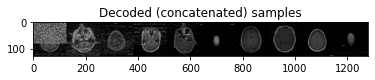

In [34]:
decoded = sign_penalty.decode_bytes_from_model()

H, W, C, order = 128, 128, 3, "CHW"
per_image_bytes = H * W * C  # 784
max_images = len(decoded) // per_image_bytes
print(f"Decoded bytes: {len(decoded)} → can reconstruct up to {max_images} images")

N = min(memorization_size, max_images)
if N == 0:
    print("Not enough capacity for a full image. Increase subset size or reduce redundancy.")
else:
    imgs = bytes_to_images_torch(decoded, n=N, h=H, w=W, c=C, order=order, device="cpu")
    print("Reconstructed tensor:", imgs.shape, imgs.dtype, imgs.min().item(), imgs.max().item())
    # Optionally visualize
    import matplotlib.pyplot as plt
    grid = torch.cat([imgs[i] for i in range(min(16, N))], dim=2)[0]
    plt.imshow(grid.numpy(), cmap="gray")
    plt.title("Decoded (concatenated) samples")
    plt.show()
    
def decode(model, sign_penalty, size = (28, 28, 1), order="CHW"):
    
    subset_selector = select_all_params     # or select_linear_head_params — must match training
    k = sign_penalty.k
    B_bits = int(sign_penalty.B_bits.item())
    
    decoded = decode_bytes_from_given_model(
        model=model,
        subset_selector=subset_selector,
        k=k,
        B_bits=B_bits,
    )
    
    # 3) Turn bytes into images (MNIST shapes)
    H, W, C = size 
    per_image_bytes = H * W * C

    max_images = len(decoded) // per_image_bytes

    imgs = bytes_to_images_torch(decoded, n=max_images, h=H, w=W, c=C, order=order, device="cpu")
    return imgs

In [35]:
imgs = decode(model, sign_penalty, size=(128, 128, 3), order="CHW")
ssim_before_pruning = calc_ssim(imgs, memorization_set, memorization_size)
print("Before pruning:")
print(f"SSIM: {ssim_before_pruning:.4f}")
test_model(model, testloader, device)

pruned_model = prune_model_global_l1(model, 0.2)
print()

print("After pruning:")
imgs = decode(pruned_model, sign_penalty, size=(128, 128, 3), order="CHW")
ssim_after_pruning = calc_ssim(imgs, memorization_set, memorization_size)
print(f"SSIM: {ssim_after_pruning:.4f}")
test_model(pruned_model, testloader, device)

Before pruning:
SSIM: 0.8223
Test Loss: 0.1544, Test DICE: 0.8675

After pruning:
SSIM: 0.5101
Test Loss: 0.1564, Test DICE: 0.8672
